# Load the datasets

In [36]:
pip install datasets

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [44]:
from datasets import load_dataset

ds = load_dataset("dair-ai/emotion", "split")

# ds = load_dataset("google-research-datasets/go_emotions", "simplified")

train_set = ds["train"]
val_set = ds["validation"]
test_set = ds["test"]

train_set = train_set.map(lambda x: {"text": x["text"], "labels": [x["label"]]})
val_set = val_set.map(lambda x: {"text": x["text"], "labels": [x["label"]]})
test_set = test_set.map(lambda x: {"text": x["text"], "labels": [x["label"]]})

Map: 100%|██████████| 2000/2000 [00:00<00:00, 23560.00 examples/s]


## First step: Inspect the dataset

In [47]:
# __emotions = [
#     'admiration',
#     'amusement',
#     'anger',
#     'annoyance',
#     'approval',
#     'caring',
#     'confusion',
#     'curiosity',
#     'desire',
#     'disappointment',
#     'disapproval',
#     'disgust',
#     'embarrassment',
#     'excitement',
#     'fear',
#     'gratitude',
#     'grief',
#     'joy',
#     'love',
#     'nervousness',
#     'optimism',
#     'pride',
#     'realization',
#     'relief',
#     'remorse',
#     'sadness',
#     'surprise',
#     'neutral'
# ]

__emotions = [
    "sadness",
    "joy",
    "love",
    "anger",
    "fear",
    "surprise",
]

EMOTION_TO_INDEX = {
    emotion: index for index, emotion in enumerate(__emotions)
}

INDEX_TO_EMOTION = {
    index: emotion for emotion, index in EMOTION_TO_INDEX.items()
}

In [48]:
# function to get the number of examples of each emotion in the dataset
def get_emotion_counts(dataset):
    emotion_counts = {}
    for example in dataset:
        for emotion_index in example["labels"]:
            emotion = INDEX_TO_EMOTION[emotion_index]
            if emotion not in emotion_counts:
                emotion_counts[emotion] = 0
            emotion_counts[emotion] += 1
    # sort the emotions in the same order as the __emotions list
    emotion_counts = {emotion: emotion_counts[emotion] for emotion in __emotions}
    return emotion_counts

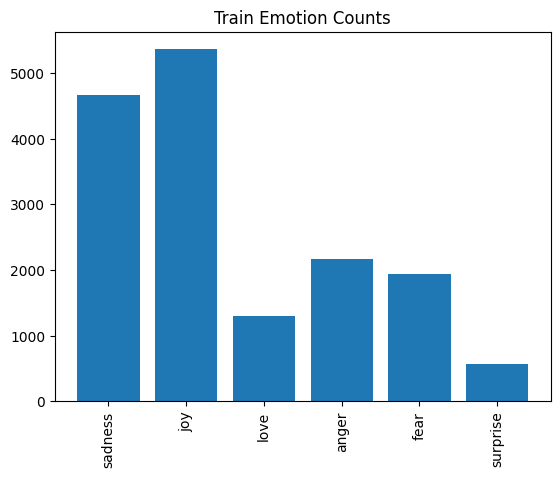

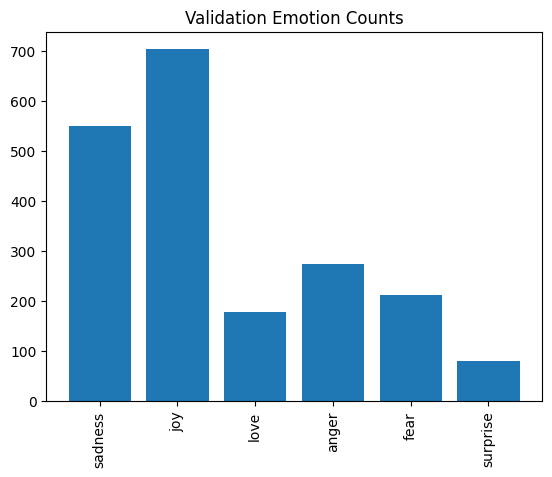

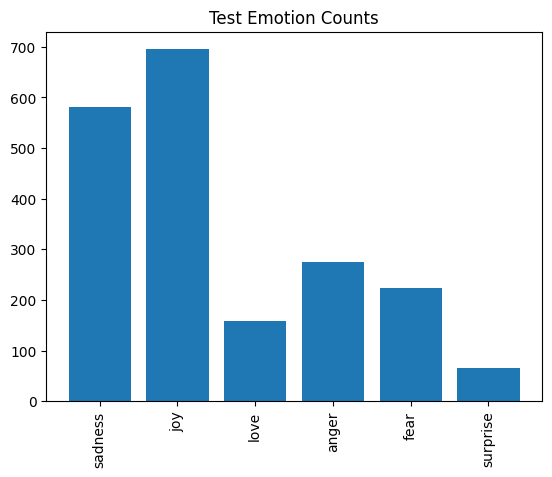

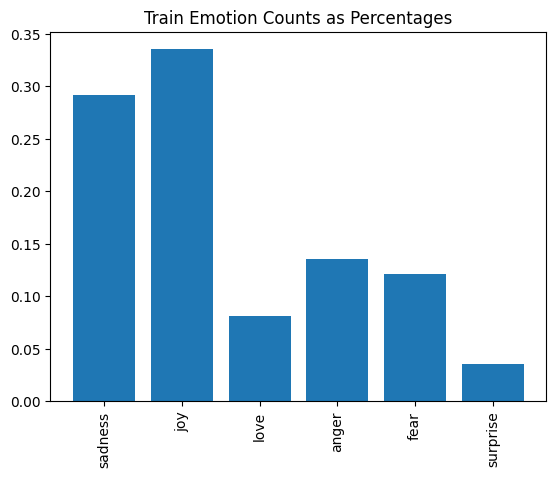

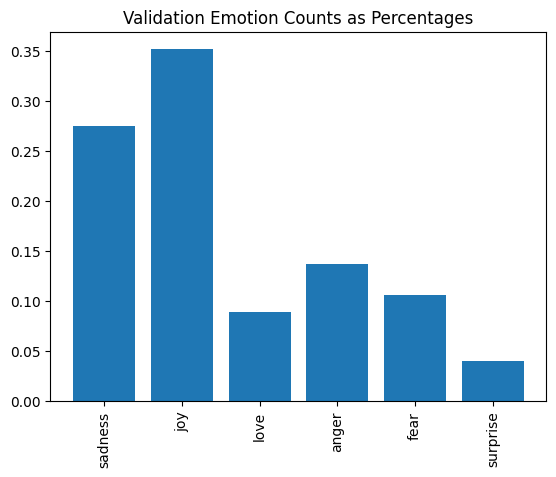

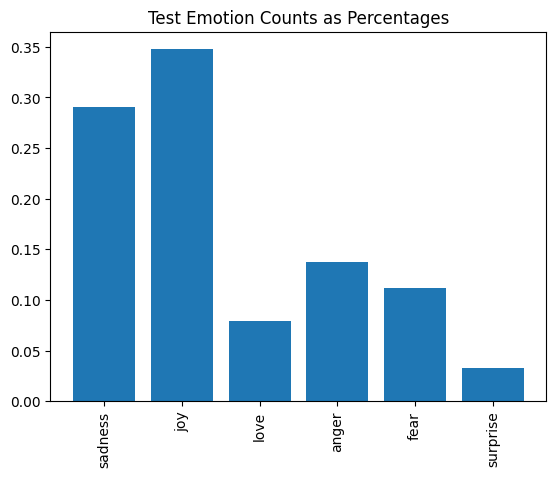

In [ ]:
train_emotion_counts = get_emotion_counts(train_set)
val_emotion_counts = get_emotion_counts(val_set)
test_emotion_counts = get_emotion_counts(test_set)

import matplotlib.pyplot as plt

def plot_emotion_counts(emotion_counts, title):
    plt.bar(emotion_counts.keys(), emotion_counts.values())
    plt.title(title)
    plt.xticks(rotation=90)
    plt.show()

def plot_emotion_counts_as_percentages(emotion_counts, title):
    total = sum(emotion_counts.values())
    percentages = {emotion: count / total for emotion, count in emotion_counts.items()}
    plt.bar(percentages.keys(), percentages.values())
    plt.title(title)
    plt.xticks(rotation=90)
    plt.show()

plot_emotion_counts(train_emotion_counts, "Train Emotion Counts")
plot_emotion_counts(val_emotion_counts, "Validation Emotion Counts")
plot_emotion_counts(test_emotion_counts, "Test Emotion Counts")

In [41]:
import spacy

# load the English language model
nlp = spacy.load('en_core_web_sm')

"""
to pre-process the data, we will always apply the following:
- lowercasing
- removing extra whitespaces
"""
def pre_process_naive_bayes(text: str) -> list[str]:
    tokens = nlp(text)
    return [token.lemma_.lower().strip() for token in tokens]

def pre_process_naive_bayes_batch(texts: list[str]) -> list[list[str]]:
    processed_texts = []
    for doc in nlp.pipe(texts, batch_size=1024):  # Adjust batch_size based on memory
        processed_texts.append([token.lemma_.lower().strip() for token in doc])
        if len(processed_texts) % 100 == 0:
            print("Processed", len(processed_texts), "texts")
    return processed_texts


texts = [example["text"] for example in train_set]
pre_processed_texts = pre_process_naive_bayes_batch(texts)
pre_processed_test_set = [
    {"text": " ".join(tokens), "labels": train_set[i]["labels"]}
    for i, tokens in enumerate(pre_processed_texts)
]



Processed 100 texts
Processed 200 texts
Processed 300 texts
Processed 400 texts
Processed 500 texts
Processed 600 texts
Processed 700 texts
Processed 800 texts
Processed 900 texts
Processed 1000 texts
Processed 1100 texts
Processed 1200 texts
Processed 1300 texts
Processed 1400 texts
Processed 1500 texts
Processed 1600 texts
Processed 1700 texts
Processed 1800 texts
Processed 1900 texts
Processed 2000 texts
Processed 2100 texts
Processed 2200 texts
Processed 2300 texts
Processed 2400 texts
Processed 2500 texts
Processed 2600 texts
Processed 2700 texts
Processed 2800 texts
Processed 2900 texts
Processed 3000 texts
Processed 3100 texts
Processed 3200 texts
Processed 3300 texts
Processed 3400 texts
Processed 3500 texts
Processed 3600 texts
Processed 3700 texts
Processed 3800 texts
Processed 3900 texts
Processed 4000 texts
Processed 4100 texts
Processed 4200 texts
Processed 4300 texts
Processed 4400 texts
Processed 4500 texts
Processed 4600 texts
Processed 4700 texts
Processed 4800 texts
P

## Unigram naive bayes model

In [9]:
emotion_count_for_words = {}

for example in pre_processed_test_set:
    for word in example["text"].split():
        if word not in emotion_count_for_words:
            emotion_count_for_words[word] = {emotion: 0 for emotion in __emotions}
        for emotion_index in example["labels"]:
            emotion = INDEX_TO_EMOTION[emotion_index]
            emotion_count_for_words[word][emotion] += 1

# put all the counts in percentages
emotion_percentage_for_words = {}
for word, emotion_counts in emotion_count_for_words.items():
    total = sum(emotion_counts.values())
    emotion_percentage_for_words[word] = {emotion: count / total for emotion, count in emotion_counts.items()}

def plot_emotion_counts_for_word(word):
    emotion_counts = emotion_count_for_words[word]
    plt.bar(emotion_counts.keys(), emotion_counts.values())
    plt.title(f"Emotion Counts for Word '{word}'")
    plt.xticks(rotation=90)
    plt.show()


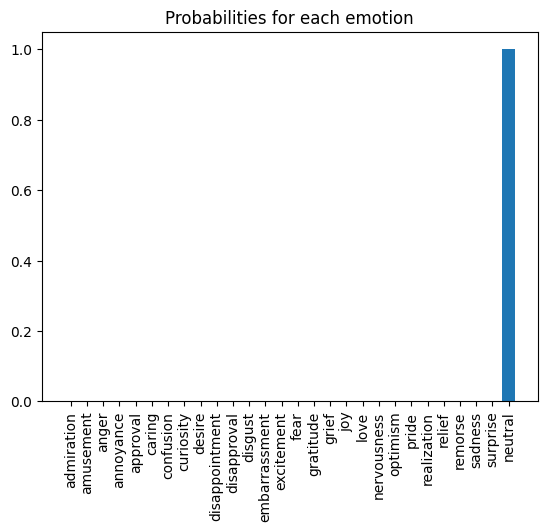

'neutral'

In [22]:
def proba_for_word_in_emotion(word, emotion):
    return emotion_percentage_for_words[word][emotion]


def proba_for_sentence_in_emotion(sentence: list[str], emotion):
    proba = 1
    for word in sentence:
        proba *= proba_for_word_in_emotion(word, emotion)
    return proba

def proba_for_sentence_for_each_emo(sentence: list[str]):
    return {emotion: proba_for_sentence_in_emotion(sentence, emotion) for emotion in __emotions}

def predict_emotion(sentence: str):
    pre_processed = pre_process_naive_bayes(sentence)
    probas = proba_for_sentence_for_each_emo(pre_processed)
    # plot the probabilities
    plt.bar(probas.keys(), probas.values())
    plt.title("Probabilities for each emotion")
    plt.xticks(rotation=90)
    plt.show()
    return max(probas, key=probas.get)

predict_emotion("horrible")

## Bigram naive bayes model

In [44]:
import math
emotion_count_for_bigrams = {}

for example in pre_processed_test_set:
    words = example["text"].split()
    for i in range(len(words) - 1):
        bigram = (words[i], words[i + 1])
        if bigram not in emotion_count_for_bigrams:
            emotion_count_for_bigrams[bigram] = {emotion: 0 for emotion in __emotions}
        for emotion_index in example["labels"]:
            emotion = INDEX_TO_EMOTION[emotion_index]
            emotion_count_for_bigrams[bigram][emotion] += 1

emotion_count_for_bigrams[("not", "happy")]

# put all the counts in percentages

emotion_percentage_for_bigrams = {}
for bigram, emotion_counts in emotion_count_for_bigrams.items():
    # total = sum(emotion_counts.values())
    emotion_percentage_for_bigrams[bigram] = {emotion: count / total for emotion, count in emotion_counts.items()}

def proba_for_bigram_in_emotion(bigram, emotion):
    # Handle missing bigrams with Laplace smoothing
    if bigram not in emotion_count_for_bigrams:
        # print("This bigram doesn't exitst apply a laplace smoothing")
        # Uniform smoothing for unseen bigrams
        return 1 / len(__emotions)  # Adjust as needed based on your smoothing strategy

    # For seen bigrams, apply Laplace smoothing
    total_count = sum(emotion_count_for_bigrams[bigram].values())
    smoothed_count = emotion_count_for_bigrams[bigram].get(emotion, 0) + 1
    return smoothed_count / (total_count + len(__emotions))


def proba_for_sentence_in_emotion_bigram(sentence: list[str], emotion):
    log_proba = 0
    for i in range(len(sentence) - 1):



        bigram = (sentence[i], sentence[i + 1])
        prob = proba_for_bigram_in_emotion(bigram, emotion)
        if prob > 0:
            log_proba += math.log(prob)
        else:
            log_proba += math.log(1 / len(__emotions))  # Smoothing for missing bigrams
    return math.exp(log_proba)

total_examples = sum(train_emotion_counts[example] for example in train_emotion_counts)
emotion_class_counts = {emotion: train_emotion_counts[emotion] for emotion in __emotions}
emotion_prior = {emotion: count / total_examples for emotion, count in emotion_class_counts.items()}
def proba_for_sentence_for_each_emo_bigram(sentence: list[str]):
    probas = {emotion: proba_for_sentence_in_emotion_bigram(sentence, emotion) for emotion in __emotions}
    # Reweight by prior probabilities
    ALPHA = 0.5  # Balance raw probabilities with priors
    probas = {emotion: (prob ** (1 - ALPHA)) * (emotion_prior[emotion] ** ALPHA) for emotion, prob in probas.items()}
    # Normalize to sum to 1
    total_proba = sum(probas.values())
    if total_proba > 0:
        probas = {emotion: prob / total_proba for emotion, prob in probas.items()}
    return probas

# def proba_for_sentence_for_each_emo_bigram(sentence: list[str]): ## Previous classes
#     return {emotion: proba_for_sentence_in_emotion_bigram(sentence, emotion) for emotion in __emotions}

def predict_emotion_bigram(sentence: str):
    pre_processed = pre_process_naive_bayes(sentence)
    probas = proba_for_sentence_for_each_emo_bigram(pre_processed)
    # plot the probabilities
    # plt.bar(probas.keys(), probas.values())
    # plt.title("Probabilities for each emotion")
    # plt.xticks(rotation=90)
    # plt.show()
    return sorted(probas.items(), key=lambda x: x[1], reverse=True)[:3]

data = test_set[2]
print(data["text"], data["labels"])
for i in range(len(data["labels"])):
    print(INDEX_TO_EMOTION[data["labels"][i]])
predict_emotion_bigram(data["text"])
# predict_emotion_bigram("Good luck")

## compute percentage:

Kings fan here, good luck to you guys! Will be an interesting game to watch!  [13]
excitement


[('neutral', 0.8143983284206544),
 ('admiration', 0.1123956488505794),
 ('optimism', 0.03625919871343113)]

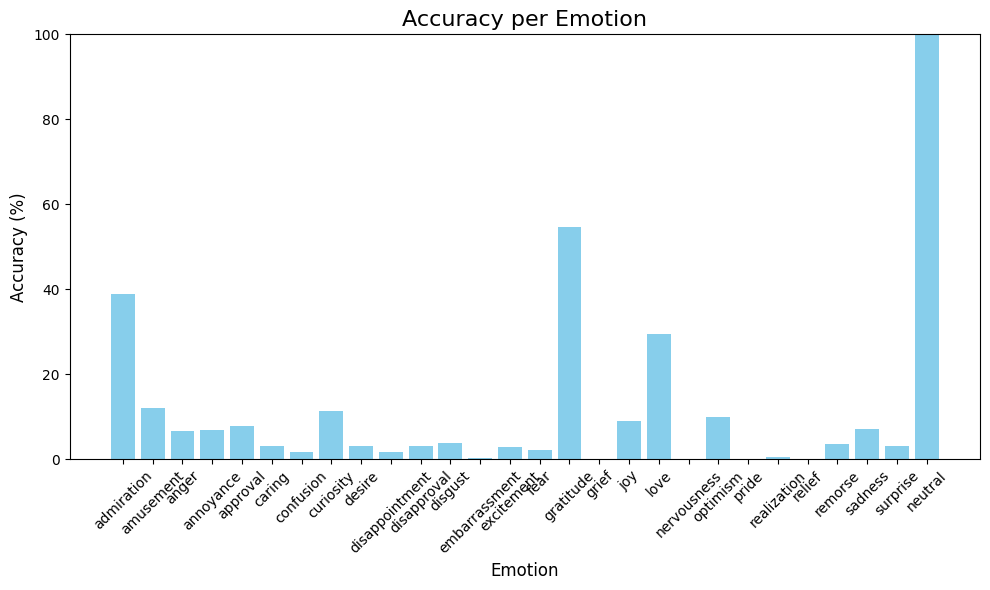

Accuracy per emotion:
admiration: 38.98%
amusement: 12.11%
anger: 6.64%
annoyance: 6.88%
approval: 7.76%
caring: 3.13%
confusion: 1.75%
curiosity: 11.32%
desire: 3.12%
disappointment: 1.73%
disapproval: 3.17%
disgust: 3.91%
embarrassment: 0.33%
excitement: 2.81%
fear: 2.18%
gratitude: 54.62%
grief: 0.00%
joy: 8.95%
love: 29.48%
nervousness: 0.00%
optimism: 9.93%
pride: 0.00%
realization: 0.54%
relief: 0.00%
remorse: 3.49%
sadness: 7.01%
surprise: 3.02%
neutral: 99.87%


In [45]:
from collections import defaultdict
import matplotlib.pyplot as plt

# Track correct predictions and total predictions for each emotion
correct_predictions = defaultdict(int)
total_predictions = defaultdict(int)

# Iterate over the test set
for example in pre_processed_test_set:
    sentence = example["text"]
    true_labels = [INDEX_TO_EMOTION[label] for label in example["labels"]]

    # Get predictions
    predicted_emotions = predict_emotion_bigram(sentence)
    top_predicted_emotion = predicted_emotions[0][0]  # Take the top prediction

    # Update counts for each true label
    for label in true_labels:
        total_predictions[label] += 1
        if top_predicted_emotion == label:
            correct_predictions[label] += 1

# Calculate accuracy for each emotion
emotion_accuracy = {emotion: (correct_predictions[emotion] / total_predictions[emotion] * 100)
                    if total_predictions[emotion] > 0 else 0
                    for emotion in __emotions}

# Plotting a single bar chart
plt.figure(figsize=(10, 6))
plt.bar(emotion_accuracy.keys(), emotion_accuracy.values(), color='skyblue')
plt.title("Accuracy per Emotion", fontsize=16)
plt.xlabel("Emotion", fontsize=12)
plt.ylabel("Accuracy (%)", fontsize=12)
plt.xticks(rotation=45)
plt.ylim(0, 100)
plt.tight_layout()
plt.show()

# Print the accuracy values
print("Accuracy per emotion:")
for emotion, accuracy in emotion_accuracy.items():
    print(f"{emotion}: {accuracy:.2f}%")
